### Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib 
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, GRU, TimeDistributed, Input, Conv1D
from keras import regularizers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras.backend as K
import _pickle as pickle
from scipy.io import loadmat
from numpy.linalg import inv
import itertools
%matplotlib inline

import matplotlib.font_manager as font_manager

font_dirs = ['/home/eevee/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 16

Using TensorFlow backend.


### Loading Data

In [2]:
import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def get_valid_RVEs(data):
    valid_rves = []
    for rve in data.keys():
        ener = data['RVE'+rve[3:]]['Sample1']['BC'+rve[3:]]['ELPD']
        if ener.shape[0]==101:
            valid_rves.append(rve[3:])
    return valid_rves

def mon_increase_error(data):
    total_error = 0.0
    for ind in range(data.shape[0]-1):
        if data[ind]-data[ind+1] > 0.0:
            total_error += data[ind]-data[ind+1]
    return total_error

In [3]:
data_list = ['Data/RVEs_postprocessing_variables1.p', 
             'Data/RVEs_postprocessing_variables2.p',
            ]

data = {}
for file in data_list:
    with open(file, 'rb') as file:
        data_local = pickle.load(file , encoding='latin1')
        data.update(data_local)
        
DOE = loadmat('Data/input_data_final_4_29.mat')

In [4]:
valid_rves = get_valid_RVEs(data)
len(valid_rves)

14677

In [66]:
rve = '3196'
ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+ data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
ener.shape

(101,)

In [5]:
energy = []
plas_energy = []
for rve in valid_rves:
    ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
    plas = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    ener = np.append(ener,np.zeros(101-len(ener)))
    plas = np.append(plas,np.zeros(101-len(plas)))
    energy.append(ener)
    plas_energy.append(plas)
energy = np.array(energy)
plas_energy = np.array(plas_energy)
energy.shape

(14677, 101)

In [6]:
stress = []
for rve in valid_rves:
    ss = data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    stress.append([s11, s22, s12])
stress = np.array(stress)
stress = stress.transpose(0,2,1)
stress.shape

(14677, 101, 3)

In [7]:
st = DOE['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
strains = []
for rve in valid_rves:
    strains.append(st[int(rve)-1,:,:])
strains = np.asarray(strains)
strains.shape

(14677, 101, 3)

### Visualizing data

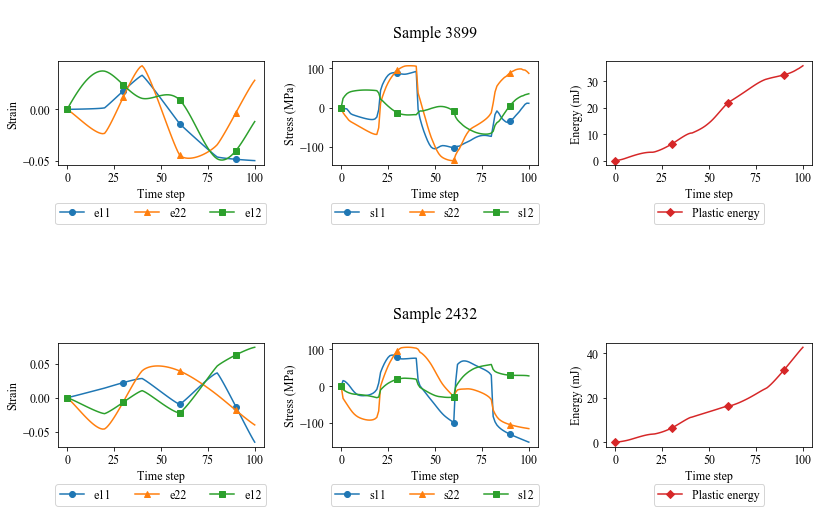

In [8]:
sample_num = 2

matplotlib.rcParams.update({'font.size': 12})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('C0', 'C1', 'C2')) 
markevery = 30

samples = random.sample(range(strains.shape[0]), sample_num)
#samples = [0,1,2]

fig, big_axes = plt.subplots( figsize=(12.0, sample_num* 4) , nrows=sample_num, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=0):
    big_ax.set_title("\nSample %d\n"
                     % (samples[row])
                     , fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top=False, bottom=False, left=False, right=False)
    big_ax._frameon = False

for i in range(sample_num):
    ax = fig.add_subplot(sample_num,3,i*3+ 1)
    ax.plot(strains[samples[i],:,0], color = next(color), marker=next(marker), markevery=markevery, label='e11')
    ax.plot(strains[samples[i],:,1], color = next(color), marker=next(marker), markevery=markevery, label='e22')
    ax.plot(strains[samples[i],:,2], color = next(color), marker=next(marker), markevery=markevery, label='e12')
    ax.set(xlabel='Time step', ylabel='Strain')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    ax = fig.add_subplot(sample_num,3,i*3+ 2)
    ax.plot(stress[samples[i],:,0], color = next(color), marker=next(marker), markevery=markevery, label = 's11')
    ax.plot(stress[samples[i],:,1], color = next(color), marker=next(marker), markevery=markevery, label = 's22')
    ax.plot(stress[samples[i],:,2], color = next(color), marker=next(marker), markevery=markevery, label = 's12')
    ax.set(xlabel='Time step', ylabel='Stress (MPa)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)
    
    ax = fig.add_subplot(sample_num,3,i*3+ 3)
    #ax.plot(energy[samples[i]], label = 'Total energy')
    ax.plot(plas_energy[samples[i]], color = 'C3', marker="D", markevery=markevery, label = 'Plastic energy')
    ax.set(xlabel='Time step', ylabel='Energy (mJ)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)
    
plt.tight_layout()
plt.show()

In [25]:
fig.savefig('input_visualization.svg', format='svg', dpi=1200)
fig.savefig('input_visualization.eps', format='eps', dpi=1200)

### Preprocessing

In [8]:
sc_e = MinMaxScaler(feature_range=(0, 1))
plas_energy_n = sc_e.fit_transform(plas_energy.reshape(-1,1))
plas_energy_norm = pd.DataFrame(data=plas_energy_n)
plas_energy_n = plas_energy_n.reshape(plas_energy.shape)
plas_energy_norm.describe()

,0
count,1.482377e+06
mean,1.988983e-01
std,1.526240e-01
min,0.000000e+00
25%,6.536018e-02
50%,1.740938e-01
75%,3.064160e-01
max,1.000000e+00


In [9]:
sc_s = MinMaxScaler(feature_range=(0, 1))
#sc_s = StandardScaler()
stress_n = sc_s.fit_transform(stress.reshape(-1,1))
stress_norm = pd.DataFrame(data=stress_n)
stress_n = stress_n.reshape(stress.shape)
stress_norm.describe()

,0
count,4.447131e+06
mean,5.561140e-01
std,1.844718e-01
min,0.000000e+00
25%,4.235765e-01
50%,5.605748e-01
75%,6.939241e-01
max,1.000000e+00


In [10]:
sc_st = MinMaxScaler(feature_range=(0, 1))
#sc_st = StandardScaler()
strain_n = sc_st.fit_transform(strains.reshape(-1,1))
strain_norm = pd.DataFrame(data=strain_n)
strain_n = strain_n.reshape(strains.shape)
strain_norm.describe()

,0
count,4.447131e+06
mean,4.740770e-01
std,1.602724e-01
min,0.000000e+00
25%,3.558695e-01
50%,4.751835e-01
75%,5.918381e-01
max,1.000000e+00


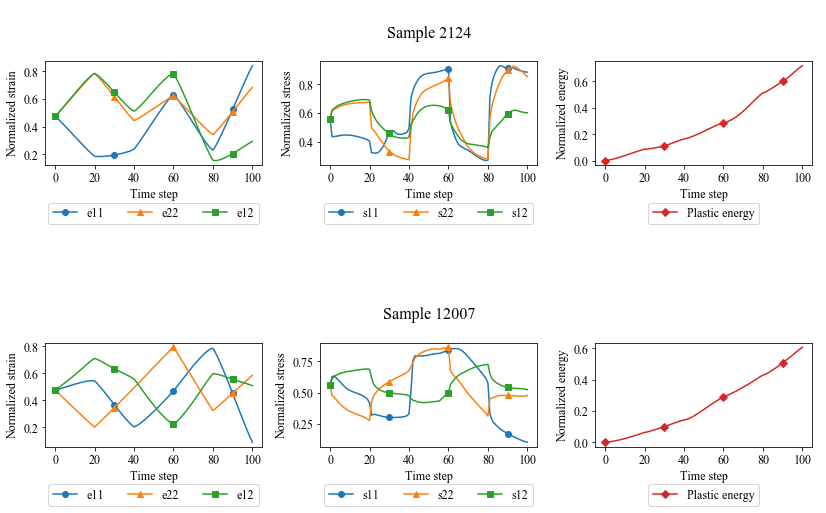

In [14]:
sample_num = 2
samples = random.sample(range(strain_n.shape[0]), sample_num)

matplotlib.rcParams.update({'font.size': 12})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('C0', 'C1', 'C2')) 
markevery = 30

fig, big_axes = plt.subplots( figsize=(12.0, sample_num* 4) , nrows=sample_num, ncols=1, sharey=True) 
for row, big_ax in enumerate(big_axes, start=0):
    big_ax.set_title("\nSample %d\n"
                     % (samples[row]),
                        fontsize=16)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top=False, bottom=False, left=False, right=False)
    big_ax._frameon = False


for i in range(sample_num):
    ax = fig.add_subplot(sample_num,3,i*3+ 1)
    ax.plot(strain_n[samples[i],:,0], color = next(color), marker=next(marker), markevery=markevery, label='e11')
    ax.plot(strain_n[samples[i],:,1], color = next(color), marker=next(marker), markevery=markevery, label='e22')
    ax.plot(strain_n[samples[i],:,2],color = next(color), marker=next(marker), markevery=markevery, label='e12')
    ax.set(xlabel='Time step', ylabel='Normalized strain')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)

    ax = fig.add_subplot(sample_num,3,i*3+ 2)
    ax.plot(stress_n[samples[i],:,0], color = next(color), marker=next(marker), markevery=markevery, label = 's11')
    ax.plot(stress_n[samples[i],:,1], color = next(color), marker=next(marker), markevery=markevery, label = 's22')
    ax.plot(stress_n[samples[i],:,2], color = next(color), marker=next(marker), markevery=markevery, label = 's12')
    ax.set(xlabel='Time step', ylabel='Normalized stress')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)
    
    ax = fig.add_subplot(sample_num,3,i*3+ 3)
    ax.plot(plas_energy_n[samples[i]], color = 'C3', marker="D", markevery=markevery, label = 'Plastic energy')
    ax.set(xlabel='Time step', ylabel='Normalized energy')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=3)
    
plt.tight_layout()
plt.show()

In [195]:
fig.savefig('input_visualization.svg', format='svg', dpi=1200)

In [11]:
x = strain_n
print(x.shape)
y = np.concatenate((np.expand_dims(plas_energy_n, axis=2), stress_n), axis=2)                              
print(y.shape)

(14677, 101, 3)
(14677, 101, 4)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11741, 101, 3)
(2936, 101, 3)
(11741, 101, 4)
(2936, 101, 4)


### Building GRU model

In [13]:
model_name = '3_500_leaky_mae'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]

In [ ]:
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, 
              activation = LR, 
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR,
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR, 
#               dropout=0.5,
             ))
# model.add(GRU(units, return_sequences=True))
model.add(TimeDistributed(Dense(output_dim)))
model.output_shape

In [89]:
#model.load_weights('3_500_1_cube_weights.h5')

In [16]:
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
#model.compile(loss='mse', optimizer='adam')

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 101, 500)          756000    
_________________________________________________________________
gru_2 (GRU)                  (None, 101, 500)          1501500   
_________________________________________________________________
gru_3 (GRU)                  (None, 101, 500)          1501500   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 101, 4)            2004      
Total params: 3,761,004
Trainable params: 3,761,004
Non-trainable params: 0
_________________________________________________________________


### Training and Results

In [18]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 11741 samples, validate on 2936 samples
Epoch 1/500
11741/11741 [==============================] - 82s 7ms/step - loss: 0.1170 - mean_squared_error: 0.0244 - val_loss: 0.0627 - val_mean_squared_error: 0.0074
Epoch 2/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0426 - mean_squared_error: 0.0037 - val_loss: 0.0341 - val_mean_squared_error: 0.0023
Epoch 3/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0269 - mean_squared_error: 0.0016 - val_loss: 0.0209 - val_mean_squared_error: 9.9124e-04
Epoch 4/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0199 - mean_squared_error: 9.2645e-04 - val_loss: 0.0202 - val_mean_squared_error: 9.0735e-04
Epoch 5/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0162 - mean_squared_error: 6.3564e-04 - val_loss: 0.0183 - val_mean_squared_error: 7.1710e-04
Epoch 6/500
11741/11741 [==================

11741/11741 [==============================] - 79s 7ms/step - loss: 0.0041 - mean_squared_error: 4.3431e-05 - val_loss: 0.0042 - val_mean_squared_error: 5.8560e-05
Epoch 92/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0042 - mean_squared_error: 4.4296e-05 - val_loss: 0.0059 - val_mean_squared_error: 8.1082e-05
Epoch 93/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0041 - mean_squared_error: 4.3120e-05 - val_loss: 0.0047 - val_mean_squared_error: 6.4662e-05
Epoch 94/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0043 - mean_squared_error: 4.5952e-05 - val_loss: 0.0045 - val_mean_squared_error: 5.7728e-05
Epoch 95/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0040 - mean_squared_error: 4.1657e-05 - val_loss: 0.0041 - val_mean_squared_error: 5.5904e-05
Epoch 96/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0041 - mean_squared_error: 4.2510e-05 - val_l

11741/11741 [==============================] - 79s 7ms/step - loss: 0.0031 - mean_squared_error: 2.2815e-05 - val_loss: 0.0038 - val_mean_squared_error: 4.8464e-05
Epoch 184/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.0976e-05 - val_loss: 0.0039 - val_mean_squared_error: 4.9769e-05
Epoch 185/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0032 - mean_squared_error: 2.3443e-05 - val_loss: 0.0038 - val_mean_squared_error: 4.7383e-05
Epoch 186/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0029 - mean_squared_error: 1.9776e-05 - val_loss: 0.0037 - val_mean_squared_error: 4.6700e-05
Epoch 187/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.0729e-05 - val_loss: 0.0035 - val_mean_squared_error: 4.4014e-05
Epoch 188/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.0560e-05 - 

11741/11741 [==============================] - 79s 7ms/step - loss: 0.0025 - mean_squared_error: 1.4382e-05 - val_loss: 0.0035 - val_mean_squared_error: 4.3885e-05
Epoch 276/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0025 - mean_squared_error: 1.4293e-05 - val_loss: 0.0037 - val_mean_squared_error: 4.6741e-05
Epoch 277/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0025 - mean_squared_error: 1.4099e-05 - val_loss: 0.0036 - val_mean_squared_error: 4.6097e-05
Epoch 278/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0023 - mean_squared_error: 1.2715e-05 - val_loss: 0.0032 - val_mean_squared_error: 4.0027e-05
Epoch 279/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0025 - mean_squared_error: 1.3639e-05 - val_loss: 0.0033 - val_mean_squared_error: 4.1949e-05
Epoch 280/500
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0024 - mean_squared_error: 1.3113e-05 - 

KeyboardInterrupt: 

In [73]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])
# print('SRMSE for train-set')
# print(np.sqrt(history.history['loss'][-1]))
# print('SRMSE for test-set')
# print(np.sqrt(history.history['val_loss'][-1]))

mean_max_inc = np.zeros((y_test.shape[0],))
for sample in range(y_test.shape[0]):
    ypred = model.predict(x_test[sample,:,:].reshape(1,101,input_dim))
    ypred = ypred.reshape((101, output_dim))
    ypred_plastic = ypred[:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease')
print(mean_max_inc.mean())

SRMSE for train-set
0.004292319038460629
SRMSE for test-set
0.0069089298126561345
SMAE for train-set
0.0028153376879819234
SMAE for test-set
0.003554570817893589
Scaled mean max plastic energy decrease
0.00018600706228027146


In [ ]:
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])

# numpy_loss_history = np.array([history.history['loss'],
#                                history.history['val_loss'],
#                               ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")
# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.set(xlabel='Time step', ylabel='MAE')
ax.set_ylim([0.0, 0.1])
ax.legend()

In [21]:
fig.savefig('convergance.svg', format='svg', dpi=1200)
fig.savefig('convergance.eps', format='eps', dpi=1200)

In [75]:
model.save('Models/'+model_name+'.h5')
model.save_weights('Models/'+model_name+'_weights.h5')

### Test-set Evaluation

In [14]:
# load model in case of leaky Relu
model_name = '3_500_leaky_mae'

LR = LeakyReLU()
LR.__name__ = 'relu'
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, 
              activation = LR, 
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR,
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR, 
             ))
model.add(TimeDistributed(Dense(output_dim)))
model.output_shape

model.load_weights('Models/'+model_name+'_weights.h5')

model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 101, 500)          756000    
_________________________________________________________________
gru_2 (GRU)                  (None, 101, 500)          1501500   
_________________________________________________________________
gru_3 (GRU)                  (None, 101, 500)          1501500   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 101, 4)            2004      
Total params: 3,761,004
Trainable params: 3,761,004
Non-trainable params: 0
_________________________________________________________________


Sample number: 7106


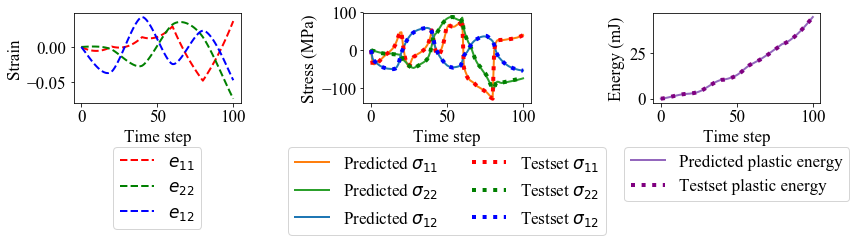

In [17]:
# model_name = '3_500_1'
# print(model_name)
# model_loaded = load_model('Models/'+model_name+'.h5')
# test_sample=np.random.randint(y_train.shape[0])
test_sample = 7106
ypred = model.predict(x_train[test_sample,:,:].reshape(1,101,input_dim))
# ypred = model.predict(x_train[test_sample,:,:].reshape(1,101,input_dim))
y_pred_s = sc_s.inverse_transform(ypred[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((101,3))
y_pred_e = sc_e.inverse_transform(ypred[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((101,1))

ytest_s = sc_s.inverse_transform(y_train[test_sample,:,1:].reshape(-1,1))
ytest_s = ytest_s.reshape((101,3))
ytest_e = sc_e.inverse_transform(y_train[test_sample,:,0].reshape(-1,1))
ytest_e = ytest_e.reshape((101,1))

x_test_sr = sc_st.inverse_transform(x_train[test_sample,:,:].reshape(-1,1))
x_test_sr = x_test_sr.reshape((101,3))

print('Sample number: '+str(test_sample))

matplotlib.rcParams.update({'font.size': 17})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12.0, 4.5))
ax1.plot(x_test_sr[:,0],'r',linestyle = '--', linewidth=2,label="$e_{11}$")
ax1.plot(x_test_sr[:,1],'g',linestyle = '--', linewidth=2,label="$e_{22}$")
ax1.plot(x_test_sr[:,2],'b',linestyle = '--', linewidth=2,label="$e_{12}$")

ax1.set(xlabel='Time step', ylabel='Strain')
lgd1 = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.plot(y_pred_s[:,0],'C1',linewidth=2,label="Predicted $\sigma_{11}$")
ax2.plot(y_pred_s[:,1],'C2',linewidth=2,label="Predicted $\sigma_{22}$")
ax2.plot(y_pred_s[:,2],'C0',linewidth=2,label="Predicted $\sigma_{12}$")

ax2.plot(ytest_s[:,0],'r', linestyle = ':',linewidth=4,label="Testset $\sigma_{11}$")
ax2.plot(ytest_s[:,1],'g', linestyle = ':',linewidth=4,label="Testset $\sigma_{22}$")
ax2.plot(ytest_s[:,2],'b' , linestyle = ':' ,linewidth=4,label="Testset $\sigma_{12}$")

ax2.set(xlabel='Time step', ylabel='Stress (MPa)')
lgd2 = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

ax3.plot(y_pred_e[:,0],'C4',linewidth=2, label="Predicted plastic energy")
ax3.plot(ytest_e[:,0],'purple', linestyle = ':',linewidth=4,label="Testset plastic energy")

ax3.set(xlabel='Time step', ylabel='Energy (mJ)')
lgd3 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

fig.tight_layout()

In [18]:
fig_name = 'trained_result_final'
fig.savefig(fig_name+'.png', format='png', dpi=1200, bbox_extra_artists=(lgd1, lgd2,lgd3), bbox_inches='tight')
fig.savefig(fig_name+'.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd1, lgd2,lgd3), bbox_inches='tight')

### Test uni-directional tension

In [19]:
with open('Data/'+'RVEs_postprocessing_variables_unidirection.p', 'rb') as file:
    test_uni_data = pickle.load(file , encoding='latin1')
    
test_uni_valid_rves = get_valid_RVEs(test_uni_data)

In [20]:
test_uni_valid_rves

['1']

In [21]:
test_uni_strains = loadmat('Data/input_data_final_unidirection.mat')

st = test_uni_strains['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
test_strains = []
for rve in test_uni_valid_rves:
    test_strains.append(st[int(rve)-1,:,:])
test_strains = np.asarray(test_strains)
test_strains.shape

(1, 101, 3)

In [22]:
test_uni_energy = []
test_uni_plas_energy = []
for rve in test_uni_valid_rves:
    ener = test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
    plas = test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    ener = np.append(ener,np.zeros(101-len(ener)))
    plas = np.append(plas,np.zeros(101-len(plas)))
    test_uni_energy.append(ener)
    test_uni_plas_energy.append(plas)
test_uni_energy = np.array(test_uni_energy)
test_uni_plas_energy = np.array(test_uni_plas_energy)

test_uni_stress = []
for rve in test_uni_valid_rves:
    ss = test_uni_data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    test_uni_stress.append([s11, s22, s12])
test_uni_stress = np.array(test_uni_stress)
test_uni_stress = test_uni_stress.transpose(0,2,1)

In [23]:
test_uni_stress.shape

(1, 101, 3)

In [24]:
test_uni_x = sc_st.transform(test_strains.reshape(-1,1))
test_uni_x = test_uni_x.reshape(test_strains.shape)


test_uni_y = np.concatenate((np.expand_dims(test_uni_plas_energy, axis=2), 
                    test_uni_stress), axis=2)  

print(test_uni_x.shape)
print(test_uni_y.shape)

(1, 101, 3)
(1, 101, 4)


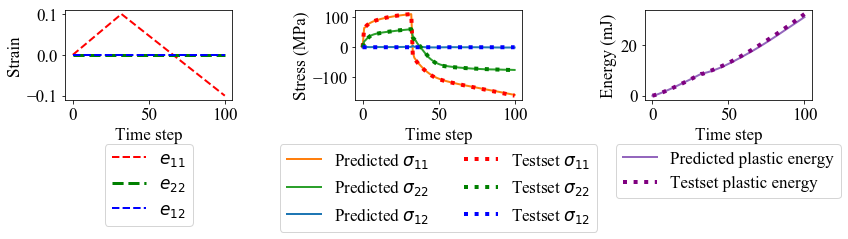

In [26]:
# model_name = '3_500_1'
# model_loaded = load_model('Models/'+model_name+'.h5')
ypred = model.predict(test_uni_x)
#ypred = ypred.reshape((101, output_dim))

y_pred_s = sc_s.inverse_transform(ypred[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((101,3))
y_pred_e = sc_e.inverse_transform(ypred[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((101,1))

ytest = test_uni_y[0,:]

test_uni_x_st = sc_st.inverse_transform(test_uni_x.reshape(-1,1))
test_uni_x_st = test_uni_x_st.reshape((101,3))

matplotlib.rcParams.update({'font.size': 17})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12.0, 4.5))

ax1.plot(test_uni_x_st[:,0],'r',linestyle = '--',linewidth=2,label="$e_{11}$")
ax1.plot(test_uni_x_st[:,1],'g',linestyle = '--',linewidth=3,label="$e_{22}$")
ax1.plot(test_uni_x_st[:,2],'b',linestyle = '--',linewidth=2,label="$e_{12}$")

ax1.set(xlabel='Time step', ylabel='Strain')
lgd1 = ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

ax2.plot(y_pred_s[:,0],'C1',linewidth=2,label="Predicted $\sigma_{11}$")
ax2.plot(y_pred_s[:,1],'C2',linewidth=2,label="Predicted $\sigma_{22}$")
ax2.plot(y_pred_s[:,2],'C0',linewidth=2,label="Predicted $\sigma_{12}$")

ax2.plot(ytest[:,1],'r', linestyle = ':',linewidth=4,label="Testset $\sigma_{11}$")
ax2.plot(ytest[:,2],'g', linestyle = ':',linewidth=4,label="Testset $\sigma_{22}$")
ax2.plot(ytest[:,3],'b' , linestyle = ':' ,linewidth=4,label="Testset $\sigma_{12}$")

ax2.set(xlabel='Time step', ylabel='Stress (MPa)')
lgd2 = ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=2)

ax3.plot(y_pred_e[:,0],'C4',linewidth=2, label="Predicted plastic energy")
ax3.plot(ytest[:,0],'purple', linestyle = ':',linewidth=4,label="Testset plastic energy")

ax3.set(xlabel='Time step', ylabel='Energy (mJ)')
lgd3 = ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=1)

fig.tight_layout()

In [27]:
fig.savefig('unidirectional.png', format='png', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')
fig.savefig('unidirectional.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd1, lgd2, lgd3), bbox_inches='tight')

In [77]:
ytest = test_uni_y[0,:]
y_test_s = sc_s.transform(test_uni_y[:,:,1:].reshape(-1,1))
y_test_s = y_test_s.reshape((1,101,3))
y_test_e = sc_e.transform(test_uni_y[:,:,0].reshape(-1,1))
y_test_e = y_test_e.reshape((1,101,1))

test_uni_y_s = np.concatenate((y_test_e,y_test_s), axis=2)


h_test = model.evaluate(test_uni_x,test_uni_y_s)
print(h_test)

1/1 [==============================] - 1s 596ms/step
[0.00345651526004076, 2.6991710910806432e-05]


### Yield surface plot

In [120]:
def pri_s(s11,s22,s12):
    if abs(s11) < 1e-3 and abs(s22) < 1e-3 and abs(s12) < 1e-3:
        return 0.0, 0.0
    theta_p = (np.arctan(2*s12/(s11-s22)))/2
    Q = np.array([[np.cos(theta_p), np.sin(theta_p)],[-1*np.sin(theta_p), np.cos(theta_p)]])
    S = np.array([[s11, s12],[s12, s22]])
    S_p = np.dot(Q, S)
    S_p = np.dot(S_p,Q.T)
#     print('s11: %.2f, s22: %.2f, s12: %.2f, theta: %.2f, s1: %.2f, s2: %.2f\n'%(s11,s22,s12,theta_p,S_p[0,0],S_p[1,1]))
    return S_p[0,0], S_p[1,1]

In [139]:
# load model in case of leaky Relu
model_name = '3_500_leaky_mae'

LR = LeakyReLU()
LR.__name__ = 'relu'
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, 
              activation = LR, 
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR,
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR, 
             ))
model.add(TimeDistributed(Dense(output_dim)))
model.output_shape

model.load_weights('Models/'+model_name+'_weights.h5')

model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')

/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [140]:
data_list = ['Data/RVEs_postprocessing_variables_yield_160.p']
DOE = loadmat('Data/input_data_final_4_29_yield_160.mat')

n_samples = 160

data = {}
for file in data_list:
    with open(file, 'rb') as file:
        data_local = pickle.load(file , encoding='latin1')
        data.update(data_local)
        
valid_rves = [str(n) for n in range(1,n_samples+1)]

energy = []
plas_energy = []
for rve in valid_rves:
    ener = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']+data['RVE'+rve]['Sample1']['BC'+rve]['ELSE']
    plas = data['RVE'+rve]['Sample1']['BC'+rve]['ELPD']
    ener = np.append(ener,np.zeros(101-len(ener)))
    plas = np.append(plas,np.zeros(101-len(plas)))
    energy.append(ener)
    plas_energy.append(plas)
energy = np.array(energy)
plas_energy = np.array(plas_energy)

stress = []
for rve in valid_rves:
    ss = data['RVE'+rve]['Sample1']['BC'+rve]['P']
    ss = np.append(ss,np.zeros((101-ss.shape[0],2,2)), axis= 0)
    s11 = ss[:,0,0]
    s12 = ss[:,0,1]
    s22 = ss[:,1,1]
    stress.append([s11, s22, s12])
stress = np.array(stress)
stress = stress.transpose(0,2,1)

st = DOE['INFO']['Realization']['Fine_strain_history'].transpose(2,0,1)
strains = []
for rve in valid_rves:
    strains.append(st[int(rve)-1,:,:])
strains = np.asarray(strains)

strain_sc = sc_st.transform(strains.reshape(-1,1))
strain_sc = strain_sc.reshape(n_samples,101,3)

In [156]:
# model_name = '3_500_1'
# model_loaded = load_model('Models/'+model_name+'.h5')
yield_y = model.predict(strain_sc)
print(yield_y.shape)
n_samples = 160
y_pred_s = sc_s.inverse_transform(yield_y[:,:,1:].reshape(-1,1))
y_pred_s = y_pred_s.reshape((n_samples,101,3))
y_pred_e = sc_e.inverse_transform(yield_y[:,:,0].reshape(-1,1))
y_pred_e = y_pred_e.reshape((n_samples,101,1))
print(y_pred_s.shape)
print(y_pred_e.shape)

(160, 101, 4)
(160, 101, 3)
(160, 101, 1)


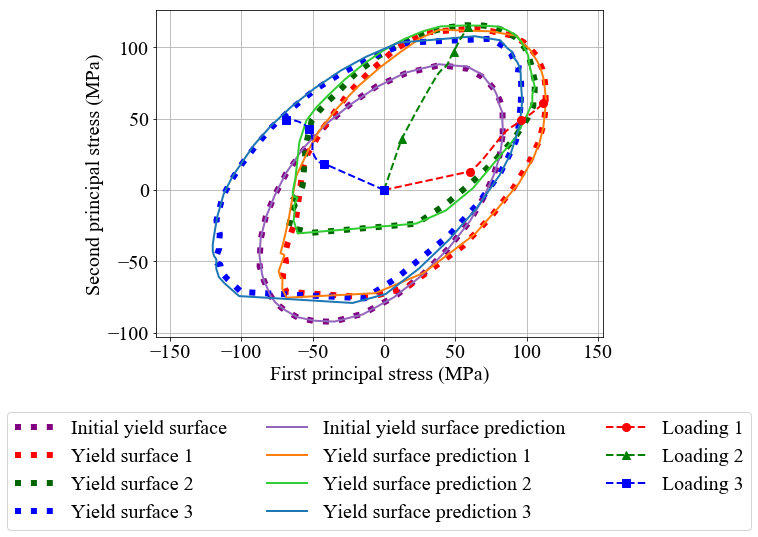

In [157]:
threshold = 1

n_samples = 40
s1_plas = np.zeros((4,n_samples,))
s2_plas = np.zeros((4,n_samples,))
s_path = np.zeros((20,51,2))

for sample in range(0,n_samples):
    for ind in range(101):
        if plas_energy[sample, ind]> threshold:
            s11_plas = stress[sample,ind,0]
            s22_plas = stress[sample,ind,1]
            s12_plas = stress[sample,ind,2]
            s1_plas[0,sample], s2_plas[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = plas_energy[start + sample, 51]
        for ind in range(51, 101):
            if plas_energy[start + sample, ind]> threshold + base_plas_energy:
                s11_plas = stress[start + sample,ind,0]
                s22_plas = stress[start + sample,ind,1]
                s12_plas = stress[start + sample,ind,2]
                s1_plas[loading+1,sample], s2_plas[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
load_id = 0
for loading in [40,80,120]:
# for loading in range(40,60):
    for ind in range(51):
        s_path[load_id,ind,:] =  pri_s(stress[loading,ind,0], stress[loading,ind,1], stress[loading,ind,2])
#         if ind>0:
#             if np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,0])>np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,1]):
#                 s_temp = s_path[load_id,ind,0]
#                 s_path[load_id,ind,0] = s_path[load_id,ind,1]
#                 s_path[load_id,ind,1] = s_temp
    load_id += 1

matplotlib.rcParams.update({'font.size': 20})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('r', 'g', 'b')) 
fig = plt.figure(figsize=(8.0, 6.0))
ax = plt.subplot(111)
plt.grid()

s1_plas_pred = np.zeros((4,n_samples,))
s2_plas_pred = np.zeros((4,n_samples,))

for sample in range(0,n_samples):
    for ind in range(101):
        if y_pred_e[sample, ind, 0]> threshold:
            s11_plas = y_pred_s[sample,ind,0]
            s22_plas = y_pred_s[sample,ind,1]
            s12_plas = y_pred_s[sample,ind,2]
            s1_plas_pred[0,sample], s2_plas_pred[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = y_pred_e[start + sample, 51,0]
        for ind in range(51, 101):
            if y_pred_e[start + sample, ind,0]> threshold + base_plas_energy:
                s11_plas = y_pred_s[start + sample,ind,0]
                s22_plas = y_pred_s[start + sample,ind,1]
                s12_plas = y_pred_s[start + sample,ind,2]
                s1_plas_pred[loading+1,sample], s2_plas_pred[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break


plt.plot(s1_plas[0], s2_plas[0], 'purple', linestyle = ':', linewidth=6, label='Initial yield surface')

plt.plot(s1_plas[1], s2_plas[1], 'r', linestyle = ':', linewidth=6, label='Yield surface 1')
plt.plot(s1_plas[2], s2_plas[2], 'darkgreen', linestyle = ':', linewidth=6, label='Yield surface 2')
plt.plot(s1_plas[3], s2_plas[3],  'b' , linestyle = ':', linewidth=6, label='Yield surface 3')

plt.plot(s1_plas_pred[0], s2_plas_pred[0], 'C4', linewidth=2, label='Initial yield surface prediction')

plt.plot(s1_plas_pred[1], s2_plas_pred[1], color = 'C1', linewidth=2, label='Yield surface prediction 1')
plt.plot(s1_plas_pred[2], s2_plas_pred[2], color = 'limegreen', linewidth=2, label='Yield surface prediction 2')
plt.plot(s1_plas_pred[3], s2_plas_pred[3], color = 'C0', linewidth=2, label='Yield surface prediction 3')

markers_on = [0, 1, 20, 50]
for i in range(3):
    plt.plot(s_path[i,:,0], s_path[i,:,1], '--',linewidth=2, color = next(color), marker=next(marker), 
             markevery=markers_on, markersize=8, label='Loading {}'.format(i+1))
#     plt.plot(s_path[i,:,0], s_path[i,:,1], '--', markevery=10, label='Loading {}'.format(i+1))

ax.set(xlabel='First principal stress (MPa)', ylabel='Second principal stress (MPa)')

plt.axis('equal')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [158]:
fig.savefig('yield_surface.png', format='png', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('yield_surface.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

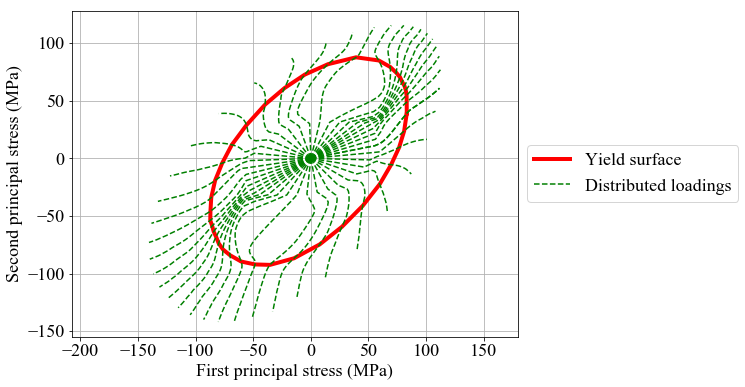

In [41]:
threshold = 1

n_samples = 40
s1_plas = np.zeros((4,n_samples,))
s2_plas = np.zeros((4,n_samples,))
s_path = np.zeros((40,101,2))

for sample in range(0,n_samples):
    for ind in range(101):
        if plas_energy[sample, ind]> threshold:
            s11_plas = stress[sample,ind,0]
            s22_plas = stress[sample,ind,1]
            s12_plas = stress[sample,ind,2]
            s1_plas[0,sample], s2_plas[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = plas_energy[start + sample, 51]
        for ind in range(51, 101):
            if plas_energy[start + sample, ind]> threshold + base_plas_energy:
                s11_plas = stress[start + sample,ind,0]
                s22_plas = stress[start + sample,ind,1]
                s12_plas = stress[start + sample,ind,2]
                s1_plas[loading+1,sample], s2_plas[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
load_id = 0
# for loading in [40,80,120]:
for loading in range(40):
    for ind in range(101):
        s_path[load_id,ind,:] =  pri_s(stress[loading,ind,0], stress[loading,ind,1], stress[loading,ind,2])
#         if ind>0:
#             if np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,0])>np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,1]):
#                 s_temp = s_path[load_id,ind,0]
#                 s_path[load_id,ind,0] = s_path[load_id,ind,1]
#                 s_path[load_id,ind,1] = s_temp
    load_id += 1

matplotlib.rcParams.update({'font.size': 18})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('g', 'b', 'C4')) 
fig = plt.figure(figsize=(8.0, 6.0))
ax = plt.subplot(111)
plt.grid()

# plt.plot(s1_plas[0], s2_plas[0], 'r', linewidth=4, label='Original Yield surface')
plt.plot(s1_plas[0], s2_plas[0], 'r', linewidth=4, label='Yield surface')
# plt.plot(s1_plas[2], s2_plas[2], 'b', linestyle = ':', linewidth=4, label='Yield surface 2')
# plt.plot(s1_plas[3], s2_plas[3], 'C4' , linestyle = ':', linewidth=4, label='Yield surface 3')

########################################### out prediction ###########################################
s1_plas_pred = np.zeros((4,n_samples,))
s2_plas_pred = np.zeros((4,n_samples,))

for sample in range(0,n_samples):
    for ind in range(101):
        if y_pred_e[sample, ind, 0]> threshold:
            s11_plas = y_pred_s[sample,ind,0]
            s22_plas = y_pred_s[sample,ind,1]
            s12_plas = y_pred_s[sample,ind,2]
            s1_plas_pred[0,sample], s2_plas_pred[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = y_pred_e[start + sample, 51,0]
        for ind in range(51, 101):
            if y_pred_e[start + sample, ind,0]> threshold + base_plas_energy:
                s11_plas = y_pred_s[start + sample,ind,0]
                s22_plas = y_pred_s[start + sample,ind,1]
                s12_plas = y_pred_s[start + sample,ind,2]
                s1_plas_pred[loading+1,sample], s2_plas_pred[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
# plt.plot(s1_plas_pred[0], s2_plas_pred[0], 'C1', linewidth=2, label='Original Yield surface prediction')
# plt.plot(s1_plas_pred[1], s2_plas_pred[1], color = 'C2', linewidth=2, label='Yield surface prediction 1')
# plt.plot(s1_plas_pred[2], s2_plas_pred[2], color = 'C0', linewidth=2, label='Yield surface prediction 1')
# plt.plot(s1_plas_pred[3], s2_plas_pred[3], color = 'purple', linewidth=2, label='Yield surface prediction 1')

for i in range(39):
#     plt.plot(s_path[i,:,0], s_path[i,:,1], '--', color = next(color), marker=next(marker), markevery=10, label='Loading {}'.format(i+1))
    plt.plot(s_path[i,:,0], s_path[i,:,1], 'g--', markevery=10)
plt.plot(s_path[39,:,0], s_path[39,:,1], 'g--', markevery=10, label='Distributed loadings')

ax.set(xlabel='First principal stress (MPa)', ylabel='Second principal stress (MPa)')

plt.axis('equal')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [42]:
fig.savefig('yield_surface_cons_1.png', format='png', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('yield_surface_cons_1.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

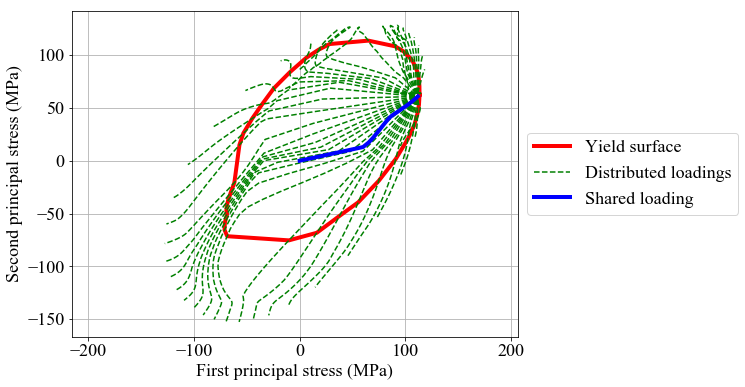

In [45]:
threshold = 1

n_samples = 40
s1_plas = np.zeros((4,n_samples,))
s2_plas = np.zeros((4,n_samples,))
s_path = np.zeros((40,101,2))

for sample in range(0,n_samples):
    for ind in range(101):
        if plas_energy[sample, ind]> threshold:
            s11_plas = stress[sample,ind,0]
            s22_plas = stress[sample,ind,1]
            s12_plas = stress[sample,ind,2]
            s1_plas[0,sample], s2_plas[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = plas_energy[start + sample, 51]
        for ind in range(51, 101):
            if plas_energy[start + sample, ind]> threshold + base_plas_energy:
                s11_plas = stress[start + sample,ind,0]
                s22_plas = stress[start + sample,ind,1]
                s12_plas = stress[start + sample,ind,2]
                s1_plas[loading+1,sample], s2_plas[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
load_id = 0
# for loading in [40,80,120]:
for loading in range(40,80):
    for ind in range(101):
        s_path[load_id,ind,:] =  pri_s(stress[loading,ind,0], stress[loading,ind,1], stress[loading,ind,2])
#         if ind>0:
#             if np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,0])>np.abs(s_path[load_id,ind,0]-s_path[load_id,ind-1,1]):
#                 s_temp = s_path[load_id,ind,0]
#                 s_path[load_id,ind,0] = s_path[load_id,ind,1]
#                 s_path[load_id,ind,1] = s_temp
    load_id += 1

matplotlib.rcParams.update({'font.size': 18})
marker = itertools.cycle(("o", "^", "s")) 
color = itertools.cycle(('g', 'b', 'C4')) 
fig = plt.figure(figsize=(8.0, 6.0))
ax = plt.subplot(111)
plt.grid()

# plt.plot(s1_plas[0], s2_plas[0], 'r', linewidth=4, label='Original Yield surface')
plt.plot(s1_plas[1], s2_plas[1], 'r', linewidth=4, label='Yield surface')
# plt.plot(s1_plas[2], s2_plas[2], 'b', linestyle = ':', linewidth=4, label='Yield surface 2')
# plt.plot(s1_plas[3], s2_plas[3], 'C4' , linestyle = ':', linewidth=4, label='Yield surface 3')

########################################### out prediction ###########################################
s1_plas_pred = np.zeros((4,n_samples,))
s2_plas_pred = np.zeros((4,n_samples,))

for sample in range(0,n_samples):
    for ind in range(101):
        if y_pred_e[sample, ind, 0]> threshold:
            s11_plas = y_pred_s[sample,ind,0]
            s22_plas = y_pred_s[sample,ind,1]
            s12_plas = y_pred_s[sample,ind,2]
            s1_plas_pred[0,sample], s2_plas_pred[0,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
            break

for loading in range(3):
    start = (loading+1) * n_samples
    for sample in range(n_samples):
        base_plas_energy = y_pred_e[start + sample, 51,0]
        for ind in range(51, 101):
            if y_pred_e[start + sample, ind,0]> threshold + base_plas_energy:
                s11_plas = y_pred_s[start + sample,ind,0]
                s22_plas = y_pred_s[start + sample,ind,1]
                s12_plas = y_pred_s[start + sample,ind,2]
                s1_plas_pred[loading+1,sample], s2_plas_pred[loading+1,sample] =  pri_s(s11_plas, s22_plas, s12_plas)
                break
                
# plt.plot(s1_plas_pred[0], s2_plas_pred[0], 'C1', linewidth=2, label='Original Yield surface prediction')
# plt.plot(s1_plas_pred[1], s2_plas_pred[1], color = 'C2', linewidth=2, label='Yield surface prediction 1')
# plt.plot(s1_plas_pred[2], s2_plas_pred[2], color = 'C0', linewidth=2, label='Yield surface prediction 1')
# plt.plot(s1_plas_pred[3], s2_plas_pred[3], color = 'purple', linewidth=2, label='Yield surface prediction 1')

for i in range(39):
#     plt.plot(s_path[i,:,0], s_path[i,:,1], '--', color = next(color), marker=next(marker), markevery=10, label='Loading {}'.format(i+1))
    plt.plot(s_path[i,:,0], s_path[i,:,1], 'g--', markevery=10)
plt.plot(s_path[39,:,0], s_path[39,:,1], 'g--', markevery=10, label='Distributed loadings')
plt.plot(s_path[0,:51,0], s_path[0,:51,1], 'b', linewidth=4, label='Shared loading')

ax.set(xlabel='First principal stress (MPa)', ylabel='Second principal stress (MPa)')

plt.axis('equal')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# lgd = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.show()

In [46]:
fig.savefig('yield_surface_cons_2.png', format='png', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig('yield_surface_cons_2.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')

### Hyperparamter analysis

### Number of nurons

In [176]:
model_name = '3_500_leaky_mae_2'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 81s 7ms/step - loss: 0.1137 - mean_squared_error: 0.0236 - val_loss: 0.0530 - val_mean_squared_error: 0.0053
Epoch 2/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0424 - mean_squared_error: 0.0036 - val_loss: 0.0309 - val_mean_squared_error: 0.0021
Epoch 3/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0255 - mean_squared_error: 0.0015 - val_loss: 0.0212 - val_mean_squared_error: 0.0010
Epoch 4/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0194 - mean_squared_error: 8.8730e-04 - val_loss: 0.0236 - val_mean_squared_error: 0.0010
Epoch 5/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0164 - mean_squared_error: 6.4783e-04 - val_loss: 0.0142 - val_mean_squared_error: 5.1228e-04
Epoch 6/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0150 - mean_squar

11741/11741 [==============================] - 79s 7ms/step - loss: 0.0045 - mean_squared_error: 4.9614e-05 - val_loss: 0.0049 - val_mean_squared_error: 6.4709e-05
Epoch 94/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0042 - mean_squared_error: 4.4361e-05 - val_loss: 0.0046 - val_mean_squared_error: 6.2847e-05
Epoch 95/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0044 - mean_squared_error: 4.6632e-05 - val_loss: 0.0054 - val_mean_squared_error: 7.3599e-05
Epoch 96/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0042 - mean_squared_error: 4.4000e-05 - val_loss: 0.0046 - val_mean_squared_error: 6.0057e-05
Epoch 97/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0039 - mean_squared_error: 4.0972e-05 - val_loss: 0.0043 - val_mean_squared_error: 5.8489e-05
Epoch 98/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0040 - mean_squared_error: 4.1574e-05 - val_l

11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.1765e-05 - val_loss: 0.0037 - val_mean_squared_error: 4.6207e-05
Epoch 186/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.0966e-05 - val_loss: 0.0041 - val_mean_squared_error: 5.1590e-05
Epoch 187/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.0637e-05 - val_loss: 0.0039 - val_mean_squared_error: 4.8391e-05
Epoch 188/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.1208e-05 - val_loss: 0.0036 - val_mean_squared_error: 4.5950e-05
Epoch 189/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0028 - mean_squared_error: 1.8817e-05 - val_loss: 0.0036 - val_mean_squared_error: 4.5052e-05
Epoch 190/200
11741/11741 [==============================] - 79s 7ms/step - loss: 0.0030 - mean_squared_error: 2.1424e-05 - 

SRMSE for train-set
0.004281374081315402
SRMSE for test-set
0.006603322737854296
SMAE for train-set
0.002784433813974104
SMAE for test-set
0.003464506664351441
Scaled mean max plastic energy decrease for train-set
0.00016595491280081364
Scaled mean max plastic energy decrease for test-set
0.00016788968357082446


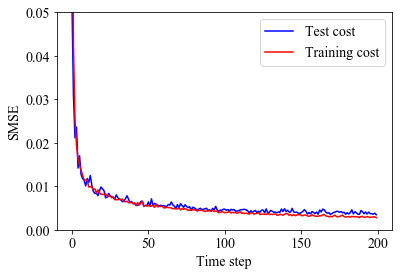

In [177]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [19]:
model_name = '3_100_leaky_mae'
units = 100
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, 
              activation = LR, 
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR,
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR, 
#               dropout=0.5,
             ))
# model.add(GRU(units, return_sequences=True))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 52s 4ms/step - loss: 0.1385 - mean_squared_error: 0.0330 - val_loss: 0.0843 - val_mean_squared_error: 0.0123
Epoch 2/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0629 - mean_squared_error: 0.0074 - val_loss: 0.0537 - val_mean_squared_error: 0.0053
Epoch 3/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0457 - mean_squared_error: 0.0040 - val_loss: 0.0390 - val_mean_squared_error: 0.0031
Epoch 4/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0391 - mean_squared_error: 0.0030 - val_loss: 0.0386 - val_mean_squared_error: 0.0028
Epoch 5/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0339 - mean_squared_error: 0.0024 - val_loss: 0.0336 - val_mean_squared_error: 0.0023
Epoch 6/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0320 - mean_squared_error: 0.

11741/11741 [==============================] - 50s 4ms/step - loss: 0.0073 - mean_squared_error: 1.5420e-04 - val_loss: 0.0081 - val_mean_squared_error: 1.7544e-04
Epoch 94/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0073 - mean_squared_error: 1.5334e-04 - val_loss: 0.0080 - val_mean_squared_error: 1.6943e-04
Epoch 95/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0075 - mean_squared_error: 1.5524e-04 - val_loss: 0.0073 - val_mean_squared_error: 1.6187e-04
Epoch 96/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0077 - mean_squared_error: 1.5936e-04 - val_loss: 0.0073 - val_mean_squared_error: 1.6784e-04
Epoch 97/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0073 - mean_squared_error: 1.5086e-04 - val_loss: 0.0072 - val_mean_squared_error: 1.5100e-04
Epoch 98/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0075 - mean_squared_error: 1.5489e-04 - val_l

11741/11741 [==============================] - 50s 4ms/step - loss: 0.0058 - mean_squared_error: 9.6085e-05 - val_loss: 0.0059 - val_mean_squared_error: 9.9303e-05
Epoch 186/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0060 - mean_squared_error: 9.9327e-05 - val_loss: 0.0055 - val_mean_squared_error: 9.5696e-05
Epoch 187/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0057 - mean_squared_error: 9.2364e-05 - val_loss: 0.0058 - val_mean_squared_error: 1.0067e-04
Epoch 188/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0057 - mean_squared_error: 9.3963e-05 - val_loss: 0.0057 - val_mean_squared_error: 9.9373e-05
Epoch 189/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0058 - mean_squared_error: 9.3038e-05 - val_loss: 0.0056 - val_mean_squared_error: 9.8314e-05
Epoch 190/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0058 - mean_squared_error: 9.6645e-05 - 

In [21]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())

SRMSE for train-set
0.00941762738552904
SRMSE for test-set
0.010031991102560823
SMAE for train-set
0.005547928140941237
SMAE for test-set
0.005781740826942859
Scaled mean max plastic energy decrease for train-set
0.0009633106348571111
Scaled mean max plastic energy decrease for test-set
0.0009410892675404896


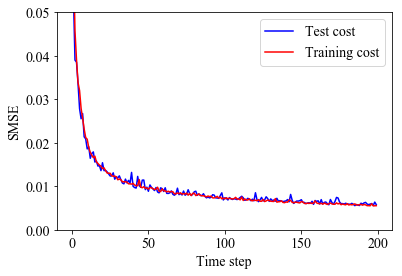

In [23]:
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [24]:
model_name = '3_1000_leaky_mae'
units = 1000
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, 
              activation = LR, 
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR,
             ))
model.add(GRU(units, return_sequences=True, 
              activation = LR, 
             ))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 172s 15ms/step - loss: 0.1183 - mean_squared_error: 0.0255 - val_loss: 0.0549 - val_mean_squared_error: 0.0053
Epoch 2/200
11741/11741 [==============================] - 171s 15ms/step - loss: 0.0411 - mean_squared_error: 0.0034 - val_loss: 0.0303 - val_mean_squared_error: 0.0019
Epoch 3/200
11741/11741 [==============================] - 171s 15ms/step - loss: 0.0253 - mean_squared_error: 0.0014 - val_loss: 0.0195 - val_mean_squared_error: 9.1065e-04
Epoch 4/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0197 - mean_squared_error: 8.7812e-04 - val_loss: 0.0148 - val_mean_squared_error: 5.5546e-04
Epoch 5/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0159 - mean_squared_error: 5.9264e-04 - val_loss: 0.0143 - val_mean_squared_error: 4.8837e-04
Epoch 6/200
11741/11741 [==============================] - 171s 15ms/step - loss:

Epoch 47/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0058 - mean_squared_error: 7.7966e-05 - val_loss: 0.0066 - val_mean_squared_error: 1.1822e-04
Epoch 48/200
11741/11741 [==============================] - 171s 15ms/step - loss: 0.0050 - mean_squared_error: 6.3735e-05 - val_loss: 0.0051 - val_mean_squared_error: 7.8146e-05
Epoch 49/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0048 - mean_squared_error: 6.0154e-05 - val_loss: 0.0063 - val_mean_squared_error: 8.8319e-05
Epoch 50/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0052 - mean_squared_error: 6.5834e-05 - val_loss: 0.0054 - val_mean_squared_error: 8.1364e-05
Epoch 51/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0050 - mean_squared_error: 6.1722e-05 - val_loss: 0.0056 - val_mean_squared_error: 8.2044e-05
Epoch 52/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0051 - mean_squared_

Epoch 93/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0035 - mean_squared_error: 3.0525e-05 - val_loss: 0.0045 - val_mean_squared_error: 6.0198e-05
Epoch 94/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0040 - mean_squared_error: 3.6392e-05 - val_loss: 0.0042 - val_mean_squared_error: 5.2705e-05
Epoch 95/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0037 - mean_squared_error: 3.2693e-05 - val_loss: 0.0057 - val_mean_squared_error: 7.7731e-05
Epoch 96/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0038 - mean_squared_error: 3.3790e-05 - val_loss: 0.0046 - val_mean_squared_error: 5.8683e-05
Epoch 97/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0038 - mean_squared_error: 3.3942e-05 - val_loss: 0.0044 - val_mean_squared_error: 5.6663e-05
Epoch 98/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0037 - mean_squared_

11741/11741 [==============================] - 170s 15ms/step - loss: 0.0027 - mean_squared_error: 1.6253e-05 - val_loss: 0.0035 - val_mean_squared_error: 4.2154e-05
Epoch 184/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0027 - mean_squared_error: 1.6476e-05 - val_loss: 0.0042 - val_mean_squared_error: 4.9882e-05
Epoch 185/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0027 - mean_squared_error: 1.6274e-05 - val_loss: 0.0035 - val_mean_squared_error: 4.2138e-05
Epoch 186/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0026 - mean_squared_error: 1.5635e-05 - val_loss: 0.0035 - val_mean_squared_error: 4.2476e-05
Epoch 187/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0027 - mean_squared_error: 1.6052e-05 - val_loss: 0.0034 - val_mean_squared_error: 4.2807e-05
Epoch 188/200
11741/11741 [==============================] - 170s 15ms/step - loss: 0.0027 - mean_squared_error: 1

In [25]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())

SRMSE for train-set
0.003902262896589393
SRMSE for test-set
0.006433019490180361
SMAE for train-set
0.002663776430655701
SMAE for test-set
0.0035178753780835494
Scaled mean max plastic energy decrease for train-set
0.0001136803065602981
Scaled mean max plastic energy decrease for test-set
0.00010694352921342087


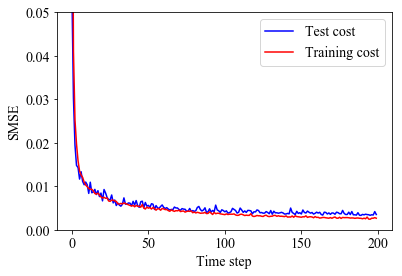

In [26]:
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

### Number of layers

In [27]:
model_name = '2_500_leaky_mae'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 52s 4ms/step - loss: 0.1127 - mean_squared_error: 0.0225 - val_loss: 0.0764 - val_mean_squared_error: 0.0099
Epoch 2/200
11741/11741 [==============================] - 51s 4ms/step - loss: 0.0494 - mean_squared_error: 0.0049 - val_loss: 0.0350 - val_mean_squared_error: 0.0027
Epoch 3/200
11741/11741 [==============================] - 51s 4ms/step - loss: 0.0330 - mean_squared_error: 0.0023 - val_loss: 0.0261 - val_mean_squared_error: 0.0016
Epoch 4/200
11741/11741 [==============================] - 51s 4ms/step - loss: 0.0239 - mean_squared_error: 0.0013 - val_loss: 0.0227 - val_mean_squared_error: 0.0013
Epoch 5/200
11741/11741 [==============================] - 51s 4ms/step - loss: 0.0194 - mean_squared_error: 9.3493e-04 - val_loss: 0.0198 - val_mean_squared_error: 8.7979e-04
Epoch 6/200
11741/11741 [==============================] - 51s 4ms/step - loss: 0.0171 - mean_squared_e

11741/11741 [==============================] - 51s 4ms/step - loss: 0.0047 - mean_squared_error: 6.0674e-05 - val_loss: 0.0051 - val_mean_squared_error: 7.8510e-05
Epoch 94/200
11741/11741 [==============================] - 52s 4ms/step - loss: 0.0045 - mean_squared_error: 5.8354e-05 - val_loss: 0.0047 - val_mean_squared_error: 6.8075e-05
Epoch 95/200
11741/11741 [==============================] - 53s 4ms/step - loss: 0.0046 - mean_squared_error: 5.8536e-05 - val_loss: 0.0056 - val_mean_squared_error: 8.2092e-05
Epoch 96/200
11741/11741 [==============================] - 52s 4ms/step - loss: 0.0045 - mean_squared_error: 5.6810e-05 - val_loss: 0.0047 - val_mean_squared_error: 7.0082e-05
Epoch 97/200
11741/11741 [==============================] - 53s 4ms/step - loss: 0.0045 - mean_squared_error: 5.6331e-05 - val_loss: 0.0048 - val_mean_squared_error: 7.2597e-05
Epoch 98/200
11741/11741 [==============================] - 52s 4ms/step - loss: 0.0045 - mean_squared_error: 5.6695e-05 - val_l

11741/11741 [==============================] - 50s 4ms/step - loss: 0.0033 - mean_squared_error: 2.9712e-05 - val_loss: 0.0039 - val_mean_squared_error: 5.1388e-05
Epoch 186/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0033 - mean_squared_error: 2.9105e-05 - val_loss: 0.0045 - val_mean_squared_error: 5.5735e-05
Epoch 187/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0033 - mean_squared_error: 2.8917e-05 - val_loss: 0.0037 - val_mean_squared_error: 5.1615e-05
Epoch 188/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0032 - mean_squared_error: 2.8375e-05 - val_loss: 0.0040 - val_mean_squared_error: 5.4401e-05
Epoch 189/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0032 - mean_squared_error: 2.8576e-05 - val_loss: 0.0041 - val_mean_squared_error: 5.4694e-05
Epoch 190/200
11741/11741 [==============================] - 50s 4ms/step - loss: 0.0032 - mean_squared_error: 2.8122e-05 - 

SRMSE for train-set
0.005094405809021599
SRMSE for test-set
0.007133072689755815
SMAE for train-set
0.0030997651923435473
SMAE for test-set
0.0036117848819654627
Scaled mean max plastic energy decrease for train-set
0.00010052542381839567
Scaled mean max plastic energy decrease for test-set
0.00010659390577046601


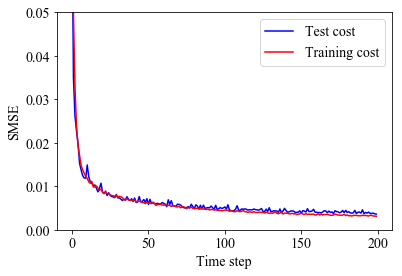

In [28]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [29]:
model_name = '1_500_leaky_mae'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
# model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.1247 - mean_squared_error: 0.0271 - val_loss: 0.0679 - val_mean_squared_error: 0.0083
Epoch 2/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0540 - mean_squared_error: 0.0057 - val_loss: 0.0428 - val_mean_squared_error: 0.0038
Epoch 3/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0382 - mean_squared_error: 0.0031 - val_loss: 0.0296 - val_mean_squared_error: 0.0021
Epoch 4/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0279 - mean_squared_error: 0.0019 - val_loss: 0.0251 - val_mean_squared_error: 0.0016
Epoch 5/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0237 - mean_squared_error: 0.0015 - val_loss: 0.0234 - val_mean_squared_error: 0.0015
Epoch 6/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0199 - mean_squared_error: 0.

11741/11741 [==============================] - 24s 2ms/step - loss: 0.0063 - mean_squared_error: 1.3215e-04 - val_loss: 0.0072 - val_mean_squared_error: 1.4702e-04
Epoch 94/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.0060 - mean_squared_error: 1.2437e-04 - val_loss: 0.0059 - val_mean_squared_error: 1.3492e-04
Epoch 95/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.0057 - mean_squared_error: 1.2076e-04 - val_loss: 0.0064 - val_mean_squared_error: 1.3548e-04
Epoch 96/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.0057 - mean_squared_error: 1.1996e-04 - val_loss: 0.0062 - val_mean_squared_error: 1.3553e-04
Epoch 97/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.0057 - mean_squared_error: 1.1900e-04 - val_loss: 0.0058 - val_mean_squared_error: 1.3036e-04
Epoch 98/200
11741/11741 [==============================] - 24s 2ms/step - loss: 0.0057 - mean_squared_error: 1.1831e-04 - val_l

11741/11741 [==============================] - 23s 2ms/step - loss: 0.0044 - mean_squared_error: 7.4046e-05 - val_loss: 0.0052 - val_mean_squared_error: 1.0261e-04
Epoch 186/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0044 - mean_squared_error: 7.4217e-05 - val_loss: 0.0051 - val_mean_squared_error: 1.0010e-04
Epoch 187/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0044 - mean_squared_error: 7.3460e-05 - val_loss: 0.0050 - val_mean_squared_error: 9.7665e-05
Epoch 188/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0045 - mean_squared_error: 7.4859e-05 - val_loss: 0.0052 - val_mean_squared_error: 9.9077e-05
Epoch 189/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0045 - mean_squared_error: 7.3569e-05 - val_loss: 0.0049 - val_mean_squared_error: 9.8054e-05
Epoch 190/200
11741/11741 [==============================] - 23s 2ms/step - loss: 0.0043 - mean_squared_error: 7.1223e-05 - 

SRMSE for train-set
0.008286930856960053
SRMSE for test-set
0.009757317445150264
SMAE for train-set
0.00422554819590594
SMAE for test-set
0.005018215551617116
Scaled mean max plastic energy decrease for train-set
0.0001523885747587002
Scaled mean max plastic energy decrease for test-set
0.00015580514729405533


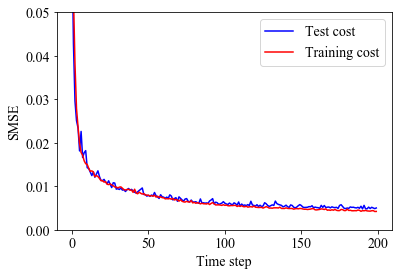

In [30]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [133]:
model_name = '5_500_leaky_mae'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=epochs, batch_size=64, verbose=1)

/home/eevee/.conda/envs/rl/lib/python3.7/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 11741 samples, validate on 2936 samples
Epoch 1/200
11741/11741 [==============================] - 139s 12ms/step - loss: 0.1460 - mean_squared_error: 0.0396 - val_loss: 0.0849 - val_mean_squared_error: 0.0113
Epoch 2/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0570 - mean_squared_error: 0.0062 - val_loss: 0.0347 - val_mean_squared_error: 0.0025
Epoch 3/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0265 - mean_squared_error: 0.0015 - val_loss: 0.0292 - val_mean_squared_error: 0.0017
Epoch 4/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0193 - mean_squared_error: 8.1758e-04 - val_loss: 0.0150 - val_mean_squared_error: 5.3773e-04
Epoch 5/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0153 - mean_squared_error: 5.3770e-04 - val_loss: 0.0137 - val_mean_squared_error: 4.3050e-04
Epoch 6/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0

Epoch 47/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0057 - mean_squared_error: 8.0337e-05 - val_loss: 0.0057 - val_mean_squared_error: 9.0656e-05
Epoch 48/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0058 - mean_squared_error: 8.1769e-05 - val_loss: 0.0056 - val_mean_squared_error: 8.0757e-05
Epoch 49/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0060 - mean_squared_error: 8.5208e-05 - val_loss: 0.0065 - val_mean_squared_error: 9.9897e-05
Epoch 50/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0059 - mean_squared_error: 8.1785e-05 - val_loss: 0.0060 - val_mean_squared_error: 9.2927e-05
Epoch 51/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0056 - mean_squared_error: 7.5300e-05 - val_loss: 0.0059 - val_mean_squared_error: 8.5874e-05
Epoch 52/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0054 - mean_squared_

Epoch 93/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0043 - mean_squared_error: 4.3860e-05 - val_loss: 0.0048 - val_mean_squared_error: 6.3954e-05
Epoch 94/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0041 - mean_squared_error: 4.1492e-05 - val_loss: 0.0044 - val_mean_squared_error: 5.6793e-05
Epoch 95/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0044 - mean_squared_error: 4.5285e-05 - val_loss: 0.0046 - val_mean_squared_error: 6.0575e-05
Epoch 96/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0041 - mean_squared_error: 4.0114e-05 - val_loss: 0.0043 - val_mean_squared_error: 6.1066e-05
Epoch 97/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0043 - mean_squared_error: 4.2756e-05 - val_loss: 0.0044 - val_mean_squared_error: 5.7493e-05
Epoch 98/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0040 - mean_squared_

11741/11741 [==============================] - 135s 11ms/step - loss: 0.0029 - mean_squared_error: 1.9593e-05 - val_loss: 0.0040 - val_mean_squared_error: 4.9303e-05
Epoch 184/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0031 - mean_squared_error: 2.0586e-05 - val_loss: 0.0045 - val_mean_squared_error: 5.3781e-05
Epoch 185/200
11741/11741 [==============================] - 135s 12ms/step - loss: 0.0029 - mean_squared_error: 1.8881e-05 - val_loss: 0.0046 - val_mean_squared_error: 5.7415e-05
Epoch 186/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0032 - mean_squared_error: 2.1646e-05 - val_loss: 0.0040 - val_mean_squared_error: 5.0739e-05
Epoch 187/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0029 - mean_squared_error: 1.8404e-05 - val_loss: 0.0045 - val_mean_squared_error: 5.5821e-05
Epoch 188/200
11741/11741 [==============================] - 135s 11ms/step - loss: 0.0031 - mean_squared_error: 2

SRMSE for train-set
0.004044453373508046
SRMSE for test-set
0.006743044920277405
SMAE for train-set
0.0026851685973476517
SMAE for test-set
0.003563088408039441
Scaled mean max plastic energy decrease for train-set
0.0001191127887151938
Scaled mean max plastic energy decrease for test-set
0.00011883563474988012


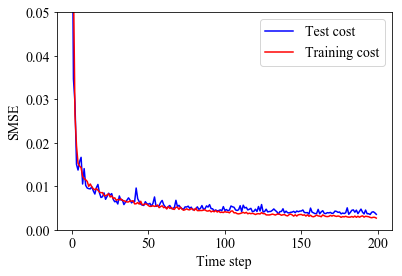

In [134]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

### Convergence test

In [31]:
x_train_alt, x_test_alt, y_train_alt, y_test_alt = train_test_split(x, y, test_size = 0.5, random_state = 1)
print(x_train_alt.shape)
print(x_test_alt.shape)
print(y_train_alt.shape)
print(y_test_alt.shape)

(7338, 101, 3)
(7339, 101, 3)
(7338, 101, 4)
(7339, 101, 4)


In [32]:
model_name = '3_500_leaky_mae_test_0.5'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train_alt, y_train_alt,validation_data=(x_test_alt,y_test_alt), epochs=epochs, batch_size=64, verbose=1)

Train on 7338 samples, validate on 7339 samples
Epoch 1/200
7338/7338 [==============================] - 63s 9ms/step - loss: 0.1445 - mean_squared_error: 0.0349 - val_loss: 0.1005 - val_mean_squared_error: 0.0167
Epoch 2/200
7338/7338 [==============================] - 63s 9ms/step - loss: 0.0705 - mean_squared_error: 0.0090 - val_loss: 0.0476 - val_mean_squared_error: 0.0044
Epoch 3/200
7338/7338 [==============================] - 63s 9ms/step - loss: 0.0417 - mean_squared_error: 0.0034 - val_loss: 0.0360 - val_mean_squared_error: 0.0025
Epoch 4/200
7338/7338 [==============================] - 62s 8ms/step - loss: 0.0313 - mean_squared_error: 0.0020 - val_loss: 0.0298 - val_mean_squared_error: 0.0017
Epoch 5/200
7338/7338 [==============================] - 63s 9ms/step - loss: 0.0234 - mean_squared_error: 0.0012 - val_loss: 0.0207 - val_mean_squared_error: 9.5799e-04
Epoch 6/200
7338/7338 [==============================] - 63s 9ms/step - loss: 0.0211 - mean_squared_error: 0.0010 - va

Epoch 48/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0069 - mean_squared_error: 1.1672e-04 - val_loss: 0.0072 - val_mean_squared_error: 1.4170e-04
Epoch 49/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0073 - mean_squared_error: 1.2630e-04 - val_loss: 0.0065 - val_mean_squared_error: 1.1612e-04
Epoch 50/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0065 - mean_squared_error: 1.0726e-04 - val_loss: 0.0064 - val_mean_squared_error: 1.0938e-04
Epoch 51/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0065 - mean_squared_error: 1.0676e-04 - val_loss: 0.0077 - val_mean_squared_error: 1.4008e-04
Epoch 52/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0064 - mean_squared_error: 1.0616e-04 - val_loss: 0.0062 - val_mean_squared_error: 1.0821e-04
Epoch 53/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0064 - mean_squared_error: 1.0464e-04 - val_

Epoch 95/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0049 - mean_squared_error: 6.0882e-05 - val_loss: 0.0052 - val_mean_squared_error: 8.1065e-05
Epoch 96/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0048 - mean_squared_error: 5.9092e-05 - val_loss: 0.0057 - val_mean_squared_error: 8.3161e-05
Epoch 97/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0049 - mean_squared_error: 5.9549e-05 - val_loss: 0.0058 - val_mean_squared_error: 8.7997e-05
Epoch 98/200
7338/7338 [==============================] - 64s 9ms/step - loss: 0.0053 - mean_squared_error: 6.7308e-05 - val_loss: 0.0050 - val_mean_squared_error: 7.5447e-05
Epoch 99/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0047 - mean_squared_error: 5.6779e-05 - val_loss: 0.0055 - val_mean_squared_error: 8.5203e-05
Epoch 100/200
7338/7338 [==============================] - 65s 9ms/step - loss: 0.0051 - mean_squared_error: 6.2542e-05 - val

7338/7338 [==============================] - 61s 8ms/step - loss: 0.0035 - mean_squared_error: 2.8090e-05 - val_loss: 0.0042 - val_mean_squared_error: 5.7496e-05
Epoch 188/200
7338/7338 [==============================] - 61s 8ms/step - loss: 0.0035 - mean_squared_error: 2.8708e-05 - val_loss: 0.0047 - val_mean_squared_error: 6.0568e-05
Epoch 189/200
7338/7338 [==============================] - 61s 8ms/step - loss: 0.0038 - mean_squared_error: 3.1557e-05 - val_loss: 0.0044 - val_mean_squared_error: 5.8329e-05
Epoch 190/200
7338/7338 [==============================] - 61s 8ms/step - loss: 0.0036 - mean_squared_error: 2.9160e-05 - val_loss: 0.0044 - val_mean_squared_error: 6.1533e-05
Epoch 191/200
7338/7338 [==============================] - 61s 8ms/step - loss: 0.0033 - mean_squared_error: 2.5731e-05 - val_loss: 0.0048 - val_mean_squared_error: 6.6092e-05
Epoch 192/200
7338/7338 [==============================] - 61s 8ms/step - loss: 0.0035 - mean_squared_error: 2.8317e-05 - val_loss: 0.

SRMSE for train-set
0.005154055533705492
SRMSE for test-set
0.007552678574598613
SMAE for train-set
0.0033762106177838494
SMAE for test-set
0.004136945412671015
Scaled mean max plastic energy decrease for train-set
0.00012647053871718493
Scaled mean max plastic energy decrease for test-set
0.0001265082441077489


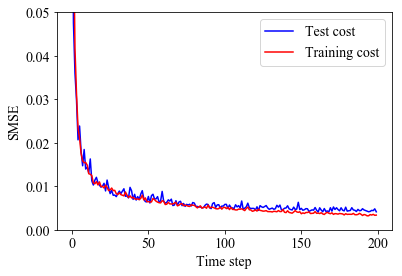

In [33]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

In [34]:
x_train_alt, x_test_alt, y_train_alt, y_test_alt = train_test_split(x, y, test_size = 0.8, random_state = 1)
print(x_train_alt.shape)
print(x_test_alt.shape)
print(y_train_alt.shape)
print(y_test_alt.shape)

(2935, 101, 3)
(11742, 101, 3)
(2935, 101, 4)
(11742, 101, 4)


In [36]:
model_name = '3_500_leaky_mae_test_0.8'
units = 500
time_span = 101
epochs = 200
input_dim = x_train.shape[2]
output_dim = y_train.shape[2]
LR = LeakyReLU()
LR.__name__ = 'relu'

K.clear_session()
model = Sequential()
model.add(GRU(units, input_shape=(time_span, input_dim), return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(GRU(units, return_sequences=True, activation = LR,))
model.add(TimeDistributed(Dense(output_dim)))
model.compile(loss='mean_absolute_error', metrics=['mse'], optimizer='adam')
history = model.fit(x_train_alt, y_train_alt,validation_data=(x_test_alt,y_test_alt), epochs=epochs, batch_size=64, verbose=1)

Train on 2935 samples, validate on 11742 samples
Epoch 1/200
2935/2935 [==============================] - 45s 15ms/step - loss: 0.1769 - mean_squared_error: 0.0513 - val_loss: 0.1411 - val_mean_squared_error: 0.0302
Epoch 2/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.1286 - mean_squared_error: 0.0256 - val_loss: 0.1151 - val_mean_squared_error: 0.0208
Epoch 3/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0980 - mean_squared_error: 0.0158 - val_loss: 0.0995 - val_mean_squared_error: 0.0178
Epoch 4/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0725 - mean_squared_error: 0.0095 - val_loss: 0.0574 - val_mean_squared_error: 0.0061
Epoch 5/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0542 - mean_squared_error: 0.0055 - val_loss: 0.0499 - val_mean_squared_error: 0.0047
Epoch 6/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0441 - mean_squared_error: 0.0038 -

Epoch 48/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0119 - mean_squared_error: 3.1720e-04 - val_loss: 0.0119 - val_mean_squared_error: 3.2503e-04
Epoch 49/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0105 - mean_squared_error: 2.6372e-04 - val_loss: 0.0097 - val_mean_squared_error: 2.4477e-04
Epoch 50/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0096 - mean_squared_error: 2.3296e-04 - val_loss: 0.0094 - val_mean_squared_error: 2.2823e-04
Epoch 51/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0089 - mean_squared_error: 2.0941e-04 - val_loss: 0.0095 - val_mean_squared_error: 2.5619e-04
Epoch 52/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0096 - mean_squared_error: 2.3458e-04 - val_loss: 0.0114 - val_mean_squared_error: 3.5059e-04
Epoch 53/200
2935/2935 [==============================] - 43s 15ms/step - loss: 0.0109 - mean_squared_error: 2.6443e-04 

2935/2935 [==============================] - 44s 15ms/step - loss: 0.0069 - mean_squared_error: 1.0475e-04 - val_loss: 0.0084 - val_mean_squared_error: 1.6828e-04
Epoch 141/200
2935/2935 [==============================] - 44s 15ms/step - loss: 0.0063 - mean_squared_error: 9.2965e-05 - val_loss: 0.0066 - val_mean_squared_error: 1.3123e-04
Epoch 142/200
2935/2935 [==============================] - 44s 15ms/step - loss: 0.0062 - mean_squared_error: 8.6730e-05 - val_loss: 0.0082 - val_mean_squared_error: 1.5418e-04
Epoch 143/200
2935/2935 [==============================] - 44s 15ms/step - loss: 0.0063 - mean_squared_error: 8.9818e-05 - val_loss: 0.0066 - val_mean_squared_error: 1.1917e-04
Epoch 144/200
2935/2935 [==============================] - 44s 15ms/step - loss: 0.0059 - mean_squared_error: 8.1094e-05 - val_loss: 0.0067 - val_mean_squared_error: 1.1827e-04
Epoch 145/200
2935/2935 [==============================] - 44s 15ms/step - loss: 0.0057 - mean_squared_error: 7.7008e-05 - val_lo

SRMSE for train-set
0.007457589959295071
SRMSE for test-set
0.009563888166825513
SMAE for train-set
0.005102494545122275
SMAE for test-set
0.005579937410194588
Scaled mean max plastic energy decrease for train-set
0.0007858292229258469
Scaled mean max plastic energy decrease for test-set
0.0007955857274396604


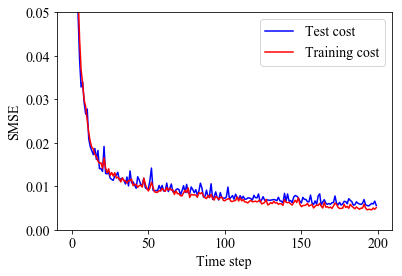

In [37]:
print('SRMSE for train-set')
print(np.sqrt(history.history['mean_squared_error'][-1]))
print('SRMSE for test-set')
print(np.sqrt(history.history['val_mean_squared_error'][-1]))
print('SMAE for train-set')
print(history.history['loss'][-1])
print('SMAE for test-set')
print(history.history['val_loss'][-1])

mean_max_inc = np.zeros((y_train.shape[0],))
ypred = model.predict(x_train)
for sample in range(y_train.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for train-set')
print(mean_max_inc.mean())

mean_max_inc = np.zeros((y_test.shape[0],))
ypred = model.predict(x_test)
for sample in range(y_test.shape[0]):
    ypred_plastic = ypred[sample,:,0]
    mean_max_inc[sample] = mon_increase_error(ypred_plastic)
print('Scaled mean max plastic energy decrease for test-set')
print(mean_max_inc.mean())
numpy_loss_history = np.array([history.history['loss'],
                               history.history['val_loss'],
                               history.history['mean_squared_error'],
                               history.history['val_mean_squared_error']
                              ])
np.savetxt('Models/'+model_name+'_loss_history.txt', numpy_loss_history, delimiter=",")

# numpy_loss_history = np.loadtxt('Models/'+model_name+'_loss_history.txt', delimiter=",")

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(numpy_loss_history[1,:],'b', label = 'Test cost')
ax.plot(numpy_loss_history[0,:],'r', label = 'Training cost')
ax.set(xlabel='Time step', ylabel='SMSE')
ax.set_ylim([0.0, 0.05])
ax.legend()

### Hyperparamter plots

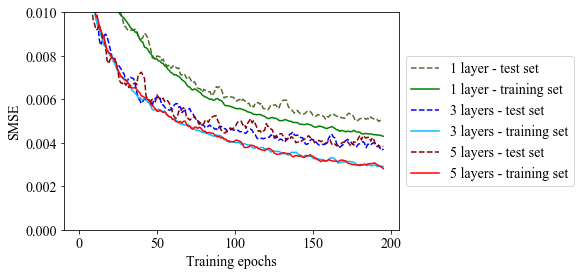

In [193]:
model_name_a = '1_500_leaky_mae'
model_name_b = '3_500_leaky_mae_2'
model_name_c = '5_500_leaky_mae'

numpy_loss_history_a = np.loadtxt('Models/'+model_name_a+'_loss_history.txt', delimiter=",")
numpy_loss_history_b = np.loadtxt('Models/'+model_name_b+'_loss_history.txt', delimiter=",")
numpy_loss_history_c = np.loadtxt('Models/'+model_name_c+'_loss_history.txt', delimiter=",")

N = 5
markevery = 100
train_a = np.convolve(numpy_loss_history_a[0,:], np.ones((N,))/N, mode='valid')
test_a = np.convolve(numpy_loss_history_a[1,:], np.ones((N,))/N, mode='valid') 

train_b = np.convolve(numpy_loss_history_b[0,:], np.ones((N,))/N, mode='valid')
test_b = np.convolve(numpy_loss_history_b[1,:], np.ones((N,))/N, mode='valid') 

train_c = np.convolve(numpy_loss_history_c[0,:], np.ones((N,))/N, mode='valid')
test_c = np.convolve(numpy_loss_history_c[1,:], np.ones((N,))/N, mode='valid') 

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(test_a,'darkolivegreen', linestyle = '--', label = '1 layer - test set')
ax.plot(train_a,'g', label = '1 layer - training set')

ax.plot(test_b,'b', linestyle = '--', label = '3 layers - test set')
ax.plot(train_b,'deepskyblue', label = '3 layers - training set')

ax.plot(test_c,'darkred', linestyle = '--', label = '5 layers - test set')
ax.plot(train_c,'r', label = '5 layers - training set')

ax.set(xlabel='Training epochs', ylabel='SMSE')
ax.set_ylim([0.0, 0.01])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [194]:
fig_name = 'hyper_analysis_n_layers'
fig.savefig(fig_name + '.svg', format='svg', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(fig_name + '.eps', format='eps', dpi=1200, bbox_extra_artists=(lgd,), bbox_inches='tight')